<p style="align: center;"><img align=center src="https://mipt.ru/docs/download.php?code=mipt_eng_text_png" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Московский физико-технический институт</b></h3>
<h3 style="text-align: center;"><b>Магистерская программа "Природные системы и безопасное освоение Арктики"</b></h3>


<h3 style="text-align: center;"><b>Детектирование микроземлетрясений.</b></h3>

    Работу выполнил: Лаврентьев Кирилл Андреевич

    Научный руководитель: Крылов Артём Александрович
    
Ссылка на [проект][] в github.


[проект]: https://github.com/KirillLavrentev/microearthquake_detection "GitHub"

### Навигация
[1. Разбиваем данные](#Разбиваем-данные-на-train/test-перед-обучением-модели)

[2. Обучение моделей](#Обучение-моделей)

   [2.1. Обучаем модель RandomForestClassifier](#Обучаем-модель-RandomForestClassifier)

   [2.2. Обучаем модель XGBClassifier](#Обучаем-модель-XGBClassifier)

[3. Проверяем модель на тестовых данных](#Проверяем-модель-на-тестовых-данных)

[4. Выводы](#Выводы)

#### В этом ноутбуке модели обучаются на фильтрованных данных.
<mark>*tr.filter('bandpass', freqmin=6, freqmax=16,corners=6)*</mark>

### Разбиваем данные на train/test перед обучением модели

In [1]:
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,f1_score
from matplotlib import pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

target = 'earthquake'

Прописываем пути к файлам.

In [2]:
# указываем тип ОС (Linux/Windows), так как на Windows запуск немного отличается
OS = 'Linux'

# откуда берем данные для построения
path = "/home/kl/Рабочий стол/Diploma_master/data/origin_in_csv_bandpass/"

# куда сохранить графики
path_image = "/home/kl/Рабочий стол/Diploma_master/graph_images/data_bandpass_marked_by_model/"

Смотрим, как выглядит объединённый файл с данными, который был подготовлен ранее.

Целевая переменная называется **earthquake**, 1 $-$ землетрясение есть, 0 $-$ землетрясения нет.

In [3]:
data = pd.read_csv('append_files_filter_bandpass.csv')
data.sample(5)

,time,620.E,620.N,620.Z,621.E,621.N,621.Z,622.E,622.N,622.Z,...,630.E,630.N,630.Z,631.E,631.N,631.Z,632.E,632.N,632.Z,earthquake
118222,2016-12-04 06:53:34.730,-3.359785,-16.603472,-4.593972,-2.192361,-4.056575,7.473060,-9.202180,-3.318137,2.106405,...,2.284015,2.050865,-3.107877,1.365425,1.988445,-0.640272,-5.789388,-1.712866,-2.312270,1.0
697751,2016-12-30 19:12:28.459900,-1.235594,-2.268023,-2.988862,-6.146954,-3.852138,-1.704822,0.413223,-4.828177,-2.566904,...,2.287634,0.338177,-3.286742,-0.360168,-0.456899,4.975273,2.569563,-0.239839,1.161999,0.0
379121,2016-12-16 09:08:54.729900,-0.577873,1.292450,0.052806,-1.612702,-0.520162,0.095535,1.355611,-0.166099,-0.477940,...,-0.739599,0.112564,-0.659581,1.403641,-0.994037,1.634529,-0.312484,3.467002,-3.083759,0.0
19376,2016-12-01 18:16:57.499900,-4.068516,4.628817,1.788315,-1.694853,-3.067676,-0.993844,-3.731582,-2.653823,-0.267741,...,-2.289951,-1.192924,0.291479,1.697679,-2.883417,-4.144638,0.565036,3.225231,-5.800160,0.0
10210,2016-12-01 18:15:25.839900,45.148710,-22.737737,39.795559,121.012784,21.206152,-20.663692,46.172274,50.263871,-11.459239,...,0.585180,2.753650,-1.624681,-0.645652,-3.002026,-0.697568,-2.609978,1.422445,0.407058,1.0


Разделяем данные на матрицу признаков $X$ и столбец ответов $y$, смотрим их размеры.

In [4]:
X = data.drop([target,'time'],axis = 1)
y = data[target]

print(X.shape)
print(y.shape)

(702000, 39)
(702000,)


Перед обучением модели данные были заранее размечены, сделано это в другом ноутбуке. Сейчас необходимо разделить данные на тренировочную и тестовую выборки.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    train_size=0.8, random_state=42)

Смотрим на размер выборок после разделения.

In [6]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(561600, 39) (140400, 39)
(561600,) (140400,)


## Обучение моделей

[В начало](#Навигация)

#### Метрика
Перед решением любой задачи важно понимать, как будет оцениваться результат. В данном случае используется стандартная для задачи классификации метрика ROC-AUC. Её можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она работает даже если классы в данных сильно несбалансированы (примеров одного класса в десятки раз больше примеров другого). Именно поэтому она очень удобна для оценки.

Посчитать её легко:

In [7]:
from sklearn.metrics import roc_auc_score

y_true = [0, 1, 1, 0, 1]
y_predictions = [0.1, 0.9, 0.4, 0.6, 0.61]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

### Обучаем модель RandomForestClassifier

[В начало](#Навигация)

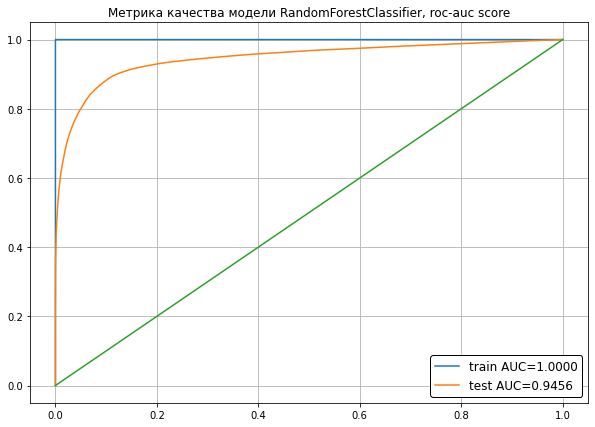

CPU times: user 42min 20s, sys: 1.41 s, total: 42min 21s
Wall time: 42min 25s


In [8]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
prediction = clf.predict_proba(X_test)

y_train_predicted = clf.predict_proba(X_train)[:, 1]
y_test_predicted = clf.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, roc_curve

train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.grid()
plt.title('Метрика качества модели RandomForestClassifier, roc-auc score')
plt.show()

При запуске с параметрами по умолчанию модель достигает точности 1.00 на тренировочных данных, но не может выдать такой же результат на тестовых данных. Это говорит о переобучении модели под тренировочные данные. Решение $-$ уменьшение глубины деревьев и увеличение минимального числа элементов в листе дерева с 1 до 5.

In [9]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100,max_depth = 25, n_jobs = -1,min_samples_split=5,max_features='log2')
clf.fit(X_train, y_train)
prediction = clf.predict_proba(X_test)

CPU times: user 28min 43s, sys: 1.19 s, total: 28min 44s
Wall time: 3min 44s


In [10]:
print('ROC-AUC score: ',round(roc_auc_score(y_test, prediction[:,1]),4))

ROC-AUC score:  0.9381
f1-score:  0.8957


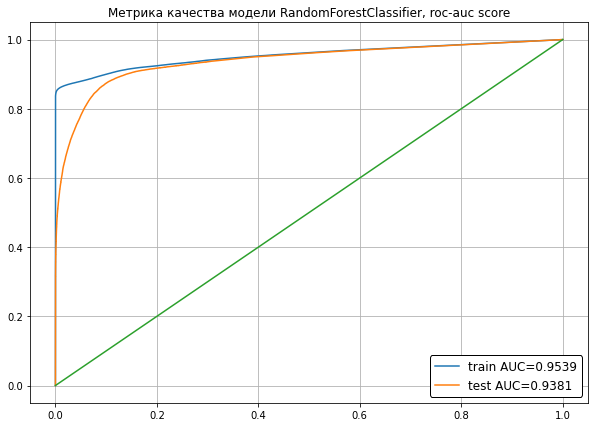

In [11]:
y_train_predicted = clf.predict_proba(X_train)[:, 1]
y_test_predicted = clf.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, roc_curve

train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.grid()
plt.title('Метрика качества модели RandomForestClassifier, roc-auc score')
plt.show()

Из графика видно, что качество на тренировочной и тестовой выборках почти совпадает, $-$ это значит, что модель не переобучается и хорошо находит зависимости.

### Обучаем модель XGBClassifier

[В начало](#Навигация)

<div class="alert alert-block alert-info">
<b>Совет.</b> Библиотека xgboost изначально не установлена в пакете Anaconda, и её необходимо установить самостоятельно для обучения следующей модели.
 <ul>
 <li> В Windows через графический интерфейс Anaconda Navigator --> environments --> search all "xgboost" --> install </li>
 <li> В Linux Ubuntu в командной строке достаточно прописать команду <b>pip install xgboost</b> </li>
 </ul>

</div>

In [12]:
%%time
boosting_model = xgboost.XGBClassifier(n_estimators=200,learning_rate = 0.1, max_depth = 5,subsample = 0.7)
boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

[13:47:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 51min 40s, sys: 1.06 s, total: 51min 41s
Wall time: 6min 45s


In [13]:
print('ROC-AUC score: ',round(roc_auc_score(y_test, y_test_predicted),4))

ROC-AUC score:  0.9392


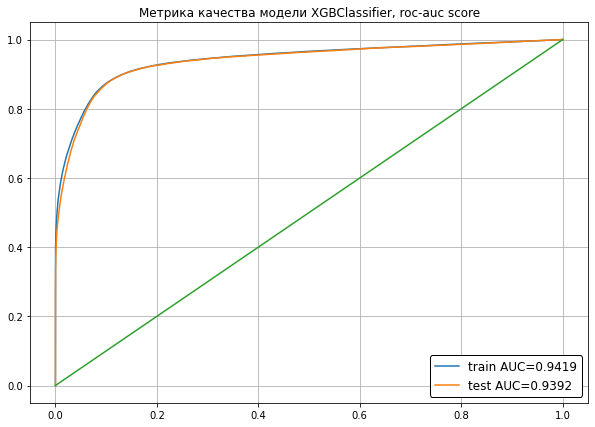

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.grid()
plt.title('Метрика качества модели XGBClassifier, roc-auc score')
plt.show()

Модель XGBClassifier ещё лучше предсказывает и меньше переобучается. 

### Проверяем модель на тестовых данных

[В начало](#Навигация)

Пусть следующие файлы, полученные из файлов miniSEED, будут тестовыми. Эти файлы модель ещё не видела, поэтому посмотрим, как хорошо модель предскажет землетрясение.


In [15]:
 # Файлы для проверки обученности модели:
test_files = [
    '2016-12-08 15:09:00.7099.csv', # четко
    '2016-12-13 01:05:03.4100.csv',
    '2016-12-13 01:52:50.7799.csv',
    '2016-12-13 15:17:59.5499.csv',
    '2016-12-13 17:23:21.2999.csv',
    '2016-12-16 16:50:56.8199.csv',
    '2016-12-17 15:58:06.3099.csv',
    '2016-12-22 05:00:42.3699.csv',
    '2016-12-23 07:42:44.7299.csv',
    '2016-12-23 13:08:15.8900.csv',
    '2016-12-23 15:27:13.1400.csv',
    '2016-12-23 15:43:14.6599.csv',
    '2016-12-25 08:49:53.1800.csv',
    '2016-12-25 14:10:05.0700.csv', # четко
    '2016-12-25 14:49:09.6099.csv',
    '2016-12-26 02:47:12.9200.csv',
    '2016-12-26 09:07:10.7799.csv',
    '2016-12-26 09:07:43.6699.csv',
    '2016-12-26 11:39:40.4399.csv',
    '2016-12-26 23:21:42.9199.csv',
    '2016-12-27 03:28:36.3899.csv', # четко
    '2016-12-27 13:45:46.3699.csv',
    '2016-12-27 14:39:25.3500.csv',
    '2016-12-27 22:58:12.1000.csv',
    '2016-12-28 03:58:11.1700.csv',
    '2016-12-28 08:34:32.4099.csv',
    '2016-12-28 20:44:27.8799.csv',
    '2016-12-28 22:49:21.1599.csv', # четко
    '2016-12-29 09:52:47.5999.csv',
    '2016-12-30 12:25:51.2500.csv',
    '2016-12-30 19:18:41.0699.csv',
    '2016-12-31 18:38:12.2700.csv',
    '2016-12-09 23:17:00.7300.csv', # не совсем четко
    '2016-12-23 03:52:15.8199.csv'       
]

if (OS == 'Windows'):
    for i in range(len(test_files)):
        try:
            test_files[i] = test_files[i].replace(':','_')
        except:
            pass

#### Используем ранее обученную модель

Далее происходит выделение границ землетрясения красным и строятся графики. Модель определяет начало и конец землетрясения, и обозначает эти метки времени для каждой станции. Программа строит все графики для каждого файла из списка *test_files* (файлы хранятся в директории *path*) и сохраняет в директорию *path_image*.

In [16]:
for kkk,file in enumerate(test_files):
    test_origin = pd.read_csv(path + file)
    test = test_origin.copy()
    X_test = test.drop(['time'],axis = 1)
    best_model = boosting_model # тут прописываем лучшую модель (boosting_model,clf, etc..)

    predict_proba = best_model.predict_proba(X_test.values)
    predict_class = best_model.predict(X_test.values)
    test_origin['predict_proba'] = test['620.E']
    test_origin['predict_class'] = test['620.E']

    test_origin['predict_proba'] = predict_proba # Предсказываем вероятность принадлежности классу
    test_origin['predict_class'] = predict_class # и сам класс
 

    #########################################################################
 #   Выделяем границы землетрясения красным
    k = 0
    count = 0
    last_element = 0
    index_sta,index_end = 0,0

    porog_start = 10 # порог начала землетрясения
    porog_end = 400 # порог конца

    print('Файл {}'.format(file))
    
    for ind, i in enumerate(test_origin['predict_class']):
        if (i==1)and(k==0):
            count+=1
        elif (i==0)and(k==1):
            count+=1
        else:
            count=0

        if (count==porog_start)and(k==0):
#             print('Время начала землетрясения: ',test_origin['time'][ind-porog_start])
            time_begin  = test_origin['time'][ind-porog_start]
            k = 1 # землетрясение началось
            index_sta = ind-porog_start
            count = 0
            continue
        if (count==porog_end)and(k==1):
            time_end = test_origin['time'][ind-porog_end]
#             print('Время окончания землетрясения: ', test_origin['time'][ind-porog_end])
            index_end = ind-porog_end
            break

####################################################################
            # строим график
    df5 = test_origin
    df5['time'] = df5['time'].apply(lambda x: pd.Timestamp(x))
    columns = list(df5.columns)[1:-2]
    date = str(df5['time'][0].date())


    for three_cols in range(0,len(columns),3):

        fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 7))

        column = columns[three_cols]
        axs[0].grid(color="blue", which="both", linestyle=':', linewidth=0.5)
        axs[0].plot(df5['time'], np.array(df5[column]), '-',color = 'grey')
        axs[0].vlines(df5['time'][index_sta], np.array(df5[column]).min(), np.array(df5[column]).max(), color = 'r',linestyle='dashed')
        axs[0].vlines(df5['time'][index_end], np.array(df5[column]).min(), np.array(df5[column]).max(), color = 'r',linestyle='dashed')
        axs[0].set_xlabel('Time')
        axs[0].set_title(column + ', ' + date)


        column = columns[three_cols+1]
        axs[1].grid(color="blue", which="both", linestyle=':', linewidth=0.5)
        axs[1].plot(df5['time'], np.array(df5[column]), '-',color = 'green')
        axs[1].vlines(df5['time'][index_sta], np.array(df5[column]).min(), np.array(df5[column]).max(), color = 'r',linestyle='dashed')
        axs[1].vlines(df5['time'][index_end], np.array(df5[column]).min(), np.array(df5[column]).max(), color = 'r',linestyle='dashed')
        axs[1].set_xlabel('Time')
        axs[1].set_title(column + ', ' + date)


        column = columns[three_cols+2]
        axs[2].grid(color="blue", which="both", linestyle=':', linewidth=0.5)
        axs[2].plot(df5['time'], np.array(df5[column]), '-',color = 'purple')
        axs[2].vlines(df5['time'][index_sta], np.array(df5[column]).min(), np.array(df5[column]).max(), color = 'r',linestyle='dashed')
        axs[2].vlines(df5['time'][index_end], np.array(df5[column]).min(), np.array(df5[column]).max(), color = 'r',linestyle='dashed')
        axs[2].set_xlabel('Time')
        axs[2].set_title(column + ', ' + date)


        plt.tight_layout()
        
        if (OS == 'Windows'):
            directory = str(df5['time'][0]) + "\\" # для Windows '\\'
            directory = directory.replace(":","_") # только для Windows делаем, т.к. папки в Windows нельзя называть с ':'
        else:
            directory = str(df5['time'][0]) + "/" # для Linux '/'
                    
        path2 = os.path.join(path_image,directory)
        try: 
            os.makedirs(path2) 
        except OSError as error: 
            pass
        
        path2 = path2 + '{}.jpeg'.format(column[:3])
        fig.savefig(path2,dpi=100)
        plt.cla()
        plt.clf()
        fig.clf()
        plt.close('all')
        plt.close(fig)
        plt.close()
        
    with open(path2[0:-8] + 'earthquake_time.txt','w') as f: # сохраняем время землетрясения в файл
        a = "Время начала землетрясения: {}".format(time_begin)
        b = "Время окончания землетрясения: {}".format(time_end)
        f.write(a)
        f.write('\n')
        f.write(b)

    plt.cla()
    plt.clf()
    fig.clf()
    plt.close('all')
    plt.close(fig)
    plt.close()
    print('Уже загрузили {} файлов.'.format(kkk + 1))
    print('Осталось загрузить ещё {} файлов.\n'.format(len(test_files)-kkk))


Файл 2016-12-08 15:09:00.7099.csv
Уже загрузили 1 файлов.
Осталось загрузить ещё 34 файлов.

Файл 2016-12-13 01:05:03.4100.csv
Уже загрузили 2 файлов.
Осталось загрузить ещё 33 файлов.

Файл 2016-12-13 01:52:50.7799.csv
Уже загрузили 3 файлов.
Осталось загрузить ещё 32 файлов.

Файл 2016-12-13 15:17:59.5499.csv
Уже загрузили 4 файлов.
Осталось загрузить ещё 31 файлов.

Файл 2016-12-13 17:23:21.2999.csv
Уже загрузили 5 файлов.
Осталось загрузить ещё 30 файлов.

Файл 2016-12-16 16:50:56.8199.csv
Уже загрузили 6 файлов.
Осталось загрузить ещё 29 файлов.

Файл 2016-12-17 15:58:06.3099.csv
Уже загрузили 7 файлов.
Осталось загрузить ещё 28 файлов.

Файл 2016-12-22 05:00:42.3699.csv
Уже загрузили 8 файлов.
Осталось загрузить ещё 27 файлов.

Файл 2016-12-23 07:42:44.7299.csv
Уже загрузили 9 файлов.
Осталось загрузить ещё 26 файлов.

Файл 2016-12-23 13:08:15.8900.csv
Уже загрузили 10 файлов.
Осталось загрузить ещё 25 файлов.

Файл 2016-12-23 15:27:13.1400.csv
Уже загрузили 11 файлов.
Осталось з

## Выводы

[В начало](#Навигация)

<div class="alert alert-block alert-success">
<b>Результат работы программы.</b> 
<ol>
 <li>Обучение происходило на фильтрованных данных, что увеличило точность моделей. </li>
 <li>Модель XGBoost с гиперпараметрами n_estimators = 200, learning_rate = 0.1, max_depth = 5, subsample = 0.7 показала лучший результат.</li>
 <li> Модель уже хорошо определяет наличие землетрясения и может обозначить его временные границы на сейсмограмме, пусть и с некоторыми ошибками.</li>
</ol>
</div>

- [x] Подготовить данные для работы, перевести их в формат csv
- [x] Визуализировать данные
- [x] Разметить файлы, опираясь на их визуализацию
- [x] Объединить файлы в датафрейм
- [x] Обучить модели, выявить лучшую
- [x] Протестировать модель, дать оценку



<div class="alert alert-block alert-info">
<b>Планы.</b>
 <ul>
 <li> Применить к данным вейвлет-преобразование.</li>
 <li> Обучить модели на новых данных, выявить лучшую модель.</li>
 </ul>

</div>
